# Adversarial Variational Optimization: Pythia benchmark

In [1]:
import torch
import hypothesis
import matplotlib.pyplot as plt

In [2]:
from hypothesis.benchmark.pythia import allocate_observations

theta_true = .5
resolution = 32
theta_true, observations = allocate_observations(theta_true, resolution=resolution)

/home/joeri/Anaconda/lib/python3.6/site-packages/pythiamill/mill.py:70: UserWarning: `seed` argument is not specified and Pythia options does not contain `Random:seed` options. This may result in duplicating samples.
  warnings.warn('`seed` argument is not specified and Pythia options does not contain `Random:seed` options. '


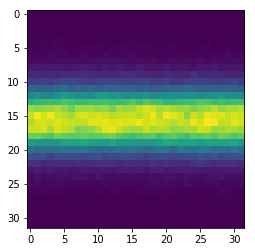

In [3]:
plt.imshow(observations.mean(dim=0).numpy())
plt.show()

## AVO

### Discriminator

In [4]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        num_hidden = 300
        self.network = torch.nn.Sequential(
            torch.nn.Linear(resolution ** 2, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.PReLU(),
            torch.nn.Linear(num_hidden, 1),
            torch.nn.Sigmoid())
        
    def forward(self, x):
        x = x.view(-1, resolution ** 2)
        y = self.network(x)
        
        return y

In [5]:
def allocate_discriminator():
    return Discriminator()

### Simulator

In [6]:
from hypothesis.benchmark.pythia import PythiaDetectorOffsetSimulator as Simulator

simulator = Simulator(resolution=resolution)

/home/joeri/Anaconda/lib/python3.6/site-packages/pythiamill/mill.py:70: UserWarning: `seed` argument is not specified and Pythia options does not contain `Random:seed` options. This may result in duplicating samples.
  warnings.warn('`seed` argument is not specified and Pythia options does not contain `Random:seed` options. '


### Proposal

In [7]:
from hypothesis.proposal import NormalProposal

proposal = NormalProposal()

### Inference

In [8]:
from hypothesis.inference import AdversarialVariationalOptimization

batch_size = 64
avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal, batch_size=batch_size)

In [9]:
proposal = avo.infer(observations, steps=10000)

/home/joeri/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


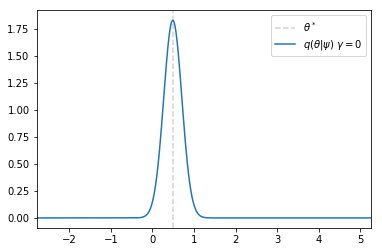

In [10]:
import matplotlib.mlab as mlab
import numpy as np

mean = proposal._mu.item()
sigma = proposal._sigma.item()
true = theta_true.item()
x = np.linspace(mean - 15 * sigma, mean + 15 * sigma + 1.5, 5000)
plt.axvline(true, linestyle="--", c="lightgray", label=r"${\theta^*}$")
plt.plot(x, mlab.normpdf(x, mean, sigma), label=r"$q({\theta}|{\psi})\ \gamma = 0$")
plt.xlim([np.min(x), np.max(x)])
plt.grid(False)
plt.legend()
plt.show()

## AVO Ensembles

In [11]:
num_runs = 15
results = []

for run in range(num_runs):
    print("Executing run", (run + 1))
    proposal = NormalProposal()
    simulator = Simulator(resolution=resolution)
    avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal, batch_size=batch_size)
    results.append(avo.infer(observations, steps=10000))

Executing run 1


/home/joeri/Anaconda/lib/python3.6/site-packages/pythiamill/mill.py:70: UserWarning: `seed` argument is not specified and Pythia options does not contain `Random:seed` options. This may result in duplicating samples.
  warnings.warn('`seed` argument is not specified and Pythia options does not contain `Random:seed` options. '


Executing run 2
Executing run 3
Executing run 4
Executing run 5
Executing run 6
Executing run 7
Executing run 8
Executing run 9
Executing run 10
Executing run 11
Executing run 12
Executing run 13
Executing run 14
Executing run 15


/home/joeri/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


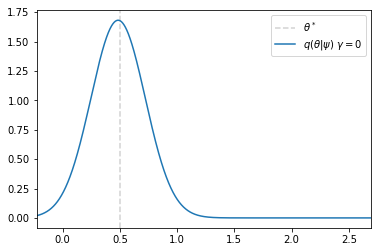

In [12]:
with torch.no_grad():
    mu = 0.
    sigma = 0.
    for proposal in results:
        mu += proposal._mu
        sigma += proposal._sigma
    mu /= num_runs
    sigma /= num_runs

averaged_proposal = NormalProposal(mu.detach(), sigma.detach())

mean = averaged_proposal._mu.item()
sigma = averaged_proposal._sigma.item()
true = theta_true.item()
x = np.linspace(mean - 3 * sigma, mean + 3 * sigma + 1.5, 5000)
plt.axvline(true, linestyle="--", c="lightgray", label=r"${\theta^*}$")
plt.plot(x, mlab.normpdf(x, mean, sigma), label=r"$q({\theta}|{\psi})\ \gamma = 0$")
plt.xlim([np.min(x), np.max(x)])
plt.grid(False)
plt.legend()
plt.show()